In [1]:
!git clone https://github.com/beckhamtoh/char-llm-assignment.git
%cd char-llm-assignment

Cloning into 'char-llm-assignment'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 77 (delta 30), reused 51 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (77/77), 30.51 MiB | 20.69 MiB/s, done.
Resolving deltas: 100% (30/30), done.
/kaggle/working/char-llm-assignment


In [2]:
# Enable autoreload of local Python modules (e.g., models)
# %load_ext autoreload
# %autoreload 2

# manual reload for local modules
import importlib

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import jax
import jax.numpy as jnp
import optax
import time

# local imports
import models.models as models
import util.generation as generation


In [4]:
# initialize the jax random key
key = jax.random.key(0)

INFO:2025-10-30 21:40:08,410:jax._src.xla_bridge:924: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-10-30 21:40:08,422:jax._src.xla_bridge:924: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


# Load data

In [5]:
# load the ./data/text8_train.txt and ./data/text8_test.txt files
with open("./data/text8_train.txt", "r") as f:
    train_text = f.read()
with open("./data/text8_test.txt", "r") as f:
    test_text = f.read()

# print the length of the training text and test text
print(f"Length of training text: {len(train_text):_} characters")
print(f"Length of test text: {len(test_text):_} characters")

Length of training text: 90_000_000 characters
Length of test text: 5_000_000 characters


In [6]:
# Build vocabulary (lowercase + space + a few punctuations)
char_set = list("abcdefghijklmnopqrstuvwxyz ")
char_to_int = {ch:i for i,ch in enumerate(char_set)}
int_to_char = {i:ch for ch,i in char_to_int.items()}

def encode(s):
    """Encode string to array of integers"""
    ids = [char_to_int[c] for c in s]
    return np.array(ids, dtype=np.uint8)  # use np.uint8 to save space

In [7]:
# encode the text
train_text_int = encode(train_text)
test_text_int = encode(test_text)

In [8]:
# sanity check: display a few random characters from the training text
T = 128
for _ in range(5):
    # choose random position in text
    N = np.random.randint(low=0, high=len(train_text)-T)
    print(train_text[N:N+T])
    print()

 by a number of different peoples speaking distinct languages conflict between the illyrians and romans started in two two nine 

ts coverage of arab world issues the israeli palestinian conflict and wider arab israeli issues are a particularly controversial

irst and last long poems mir io and lou pouemo dou rose both full scale epics in one two cantos mir io which is set in the poet 

rnfield after a heated argument parks walked out and his partnership with wilson came to an abrupt end many factors combined to 

thwest it is important to understand three limitations in the current conventions archaeological research focuses on items left 



# Create a basic Transformer model

In [9]:
def create_train_state(rng, model_type="transformer", vocab_size=27, d_model=64, n_layers=6, n_heads=8, max_len=128):
    """Create model and initialize parameters.
    
    Args:
        model_type: either "transformer" or "lstm"
        other args same as before
    """
    if model_type == "lstm":
        # create LSTM model (doesn't need n_heads or max_len)
        model = models.CharLSTM(vocab_size, d_model, n_layers)
    else:
        # create a basic Transformer model
        model = models.DecoderOnlyTransformer(vocab_size, d_model, n_layers, n_heads, max_len)
    
    # create a dummy input for initialization
    dummy = jnp.zeros((1, min(16, max_len)), dtype=jnp.int32)
    # pass the dummy input to the model to initialize the parameters
    params = model.init({"params": rng}, dummy)["params"]
    return model, params

In [10]:
# vocab size
vocab_size= len(char_set)

# internal model dimensions
d_model=256

# number of attention heads
n_heads=8

# number of Transformer layers
n_layers=2

# maximum sequence length
max_len=128

# Choose model type: "transformer" or "lstm"
model_type = "lstm"  # Change this to "transformer" to use transformer

model, params = create_train_state(key, model_type=model_type, vocab_size=vocab_size, 
                                   d_model=d_model, n_layers=n_layers, 
                                   n_heads=n_heads, max_len=max_len)

In [11]:
# compute the number of parameters
def count_params(params):
    return sum(x.size for x in jax.tree_util.tree_leaves(params))
print(f"Number of parameters: {count_params(params):_}")

Number of parameters: 1_064_448


In [12]:
# sanity check: create a batch of data & run a forward pass
B, T = 4, 32
batch = jax.random.randint(
    key=key,
    shape=(B, T), minval=0, maxval=len(char_set))
logits = model.apply({"params": params}, batch)

print("batch shape:", batch.shape)  # (B, T)
print("logits shape:", logits.shape)  # (B, T, vocab_size)

batch shape: (4, 32)
logits shape: (4, 32, 27)


# Loss function

In [13]:
@jax.jit
def loss_and_metrics(logits, targets):
    """Compute cross-entropy loss and accuracy.

    Assumes `targets` contains only valid integer class ids in [0, V-1] (no -1 ignore tokens).

    Args:
      logits: (B, T, V) float array of unnormalized scores.
      targets: (B, T) integer array with ground-truth class ids.

    Returns:
      loss: scalar average cross-entropy over all positions.
      metrics: dict with keys "loss" and "acc" (both scalars).
    """
    # Flatten batch/time dims so optax works on shape (N, V) and (N,)
    vocab = logits.shape[-1]
    flat_logits = logits.reshape(-1, vocab)
    flat_targets = targets.reshape(-1)

    # Per-position cross-entropy, then mean over all positions
    per_pos = optax.softmax_cross_entropy_with_integer_labels(flat_logits, flat_targets)
    loss = per_pos.mean()

    # prediction over all positions
    preds = jnp.argmax(logits, axis=-1)  # (B, T)

    # compute accuracy over only the last position
    is_match = preds == targets

    # Accuracy over all positions
    acc_all = jnp.mean(is_match.astype(jnp.float32))

    # Accuracy over only last position
    acc_last = jnp.mean(is_match.astype(jnp.float32)[:,-1])

    return loss, {"loss": loss, "acc": acc_all, "acc_last": acc_last}

# Optimization step:

In [14]:
# create an update function
def train_step(params, opt_state, x, y, tx):
    """Single optimization step using optax optimizer.

    Args:
      params: pytree of model parameters.
      opt_state: optax optimizer state corresponding to `params`.
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
      tx: optax.GradientTransformation (already initialized).

    Returns:
      new_params: updated parameters after one gradient step.
      new_opt_state: updated optimizer state.
      metrics: dict of scalar metrics (loss, acc).
    """
    def loss_fn(params):
        logits = model.apply({"params": params}, x)
        loss, metrics = loss_and_metrics(logits, y)
        return loss, metrics

    # compute gradients (loss is scalar, metrics is auxiliary)
    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # optax update: compute parameter updates and new optimizer state
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, metrics

# jit: last argument should be static because it is an object
train_step = jax.jit(train_step, static_argnames=("tx",))

# Batch creation:

In [15]:
# create a batch from the training data
def get_batch(text_int, B, T):
    """Create a random batch of data from text_int.

    Args:
      text_int: 1D array of token ids.
      B: batch size (number of sequences).
      T: sequence length (number of tokens per sequence).

    Returns:
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
    """
    # choose random starting indices for each sequence in the batch
    ix = np.random.randint(0, len(text_int) - T, size=B)
    # inputs are text from i to i+T
    x = np.stack([text_int[i:i+T] for i in ix])
    # targets are text from i+1 to i+T+1
    y = np.stack([text_int[i+1:i+T+1] for i in ix])
    return jnp.array(x, dtype=jnp.int32), jnp.array(y, dtype=jnp.int32)

# Optimizer creation:

In [16]:
# define optax optimizer
learning_rate = 0.001
# Create Adam optimizer (Optax)
tx = optax.adam(learning_rate=learning_rate)
# Initialize optimizer state for current params
opt_state = tx.init(params)
print(f"Initialized optimizer: Adam lr={learning_rate}")



Initialized optimizer: Adam lr=0.001


In [17]:
niter = 100_000
B, T = 128, 32
loss_history = []
time_history = []
time_test_history = []
loss_test_history = []
time_start = time.time()
for it in range(niter):
    batch = get_batch(train_text_int, B, T)
    input, target = batch[0], batch[1]
    params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, tx)

    # update params and opt_state
    params = params_new
    opt_state = opt_state_new
    acc = metrics['acc']
    acc_last = metrics['acc_last']
    loss = metrics['loss']

    loss_history.append(loss)
    time_history.append(time.time() - time_start)

    if it % (niter // 50) == 0 or it == niter - 1:
        time_since_start = time.time() - time_start
        # compute loss on test set
        B_test, T_test = 1024, 32
        test_batch = get_batch(test_text_int, B_test, T_test)
        test_input, test_target = test_batch[0], test_batch[1]
        test_logits = model.apply({"params": params}, test_input)
        test_loss, test_metrics = loss_and_metrics(test_logits, test_target)
        test_acc = test_metrics['acc']
        test_acc_last = test_metrics['acc_last']
        loss_test_history.append(test_loss)
        time_test_history.append(time_since_start)
        print(f"iteration {it:_}  time: {time_since_start:.1f} seconds")
        print(f"\t \t loss(train :: test): {loss:.4f} :: {test_loss:.4f}")
        print(f"\t \t accuracy (train :: test): {100*acc:.1f}% :: {100*test_acc:.1f}%")
        print(f"\t \t accuracy (last character) (train :: test): {100*acc_last:.1f}% :: {100*test_acc_last:.1f}%")
        print()


iteration 0  time: 17.3 seconds
	 	 loss(train :: test): 3.2960 :: 3.2824
	 	 accuracy (train :: test): 2.6% :: 16.9%
	 	 accuracy (last character) (train :: test): 3.9% :: 17.7%

iteration 2_000  time: 45.9 seconds
	 	 loss(train :: test): 1.4628 :: 1.4668
	 	 accuracy (train :: test): 54.6% :: 54.9%
	 	 accuracy (last character) (train :: test): 54.7% :: 56.2%

iteration 4_000  time: 74.2 seconds
	 	 loss(train :: test): 1.4221 :: 1.4202
	 	 accuracy (train :: test): 56.0% :: 55.8%
	 	 accuracy (last character) (train :: test): 54.7% :: 60.1%

iteration 6_000  time: 103.9 seconds
	 	 loss(train :: test): 1.4306 :: 1.3824
	 	 accuracy (train :: test): 55.4% :: 57.0%
	 	 accuracy (last character) (train :: test): 53.1% :: 61.1%

iteration 8_000  time: 134.9 seconds
	 	 loss(train :: test): 1.3769 :: 1.3545
	 	 accuracy (train :: test): 57.2% :: 57.6%
	 	 accuracy (last character) (train :: test): 53.9% :: 59.9%

iteration 10_000  time: 166.1 seconds
	 	 loss(train :: test): 1.3145 :: 1

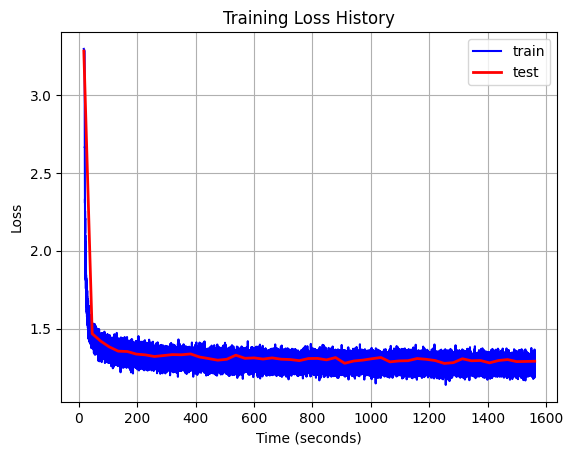

In [18]:
# plot the loss history
import matplotlib.pyplot as plt
plt.plot(time_history, loss_history, '-', label='train', color="blue")
plt.plot(time_test_history, loss_test_history, '-', label='test', lw=2, color="red")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title("Training Loss History")
plt.grid()

In [19]:
# Generation (only works with transformer)
if model_type == "transformer":
    B = 1
    seed = 42
    rng = jax.random.PRNGKey(seed)
    prompt = "hello my fri"
    # prompt_int = encode(prompt.lower())
    prompt_int = jnp.array([ [char_to_int.get(c, len(char_set)) for c in prompt.lower()[:64]] ], dtype=jnp.int32)
    gen_len = 1000
    out_ids = generation.generate_tokens(model, params, rng, prompt_int, gen_len, block_size=64, temperature=0.7, sample=True)
    print('generated ids shape:', out_ids.shape)
    print('generated text:')
    generated_text = ''.join(int_to_char.get(int(x), '?') for x in list(out_ids[0]))
    # concatenate with prompt
    print(prompt + generated_text)
else:
    print(f"Generation skipped for {model_type} model.")
    print("LSTM model trained successfully. Check test accuracy above.")

Generation skipped for lstm model.
LSTM model trained successfully. Check test accuracy above.
